<a href="https://colab.research.google.com/github/ChangruiCai/Assignment/blob/main/Main_Falling_Beam_N_nodes_demo_Fixed_DOFs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [360]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output # Only for iPython

#Helper function

In [361]:
def crossMat(a):
    """
    Returns the cross product matrix of vector 'a'.

    Parameters:
    a : np.ndarray
        A 3-element array representing a vector.

    Returns:
    A : np.ndarray
        The cross product matrix corresponding to vector 'a'.
    """
    A = np.array([[0, -a[2], a[1]],
                  [a[2], 0, -a[0]],
                  [-a[1], a[0], 0]])

    return A

#Gradient and Hessian of elastic energies

In [362]:
def gradEb(xkm1, ykm1, xk, yk, xkp1, ykp1, curvature0, l_k, EI):
    """
    Returns the derivative of bending energy E_k^b with respect to
    x_{k-1}, y_{k-1}, x_k, y_k, x_{k+1}, and y_{k+1}.

    Parameters:
    xkm1, ykm1 : float
        Coordinates of the previous node (x_{k-1}, y_{k-1}).
    xk, yk : float
        Coordinates of the current node (x_k, y_k).
    xkp1, ykp1 : float
        Coordinates of the next node (x_{k+1}, y_{k+1}).
    curvature0 : float
        Discrete natural curvature at node (xk, yk).
    l_k : float
        Voronoi length of node (xk, yk).
    EI : float
        Bending stiffness.

    Returns:
    dF : np.ndarray
        Derivative of bending energy.
    """

    # Nodes in 3D
    node0 = np.array([xkm1, ykm1, 0.0])
    node1 = np.array([xk, yk, 0])
    node2 = np.array([xkp1, ykp1, 0])

    # Unit vectors along z-axis
    m2e = np.array([0, 0, 1])
    m2f = np.array([0, 0, 1])

    kappaBar = curvature0

    # Initialize gradient of curvature
    gradKappa = np.zeros(6)

    # Edge vectors
    ee = node1 - node0
    ef = node2 - node1

    # Norms of edge vectors
    norm_e = np.linalg.norm(ee)
    norm_f = np.linalg.norm(ef)

    # Unit tangents
    te = ee / norm_e
    tf = ef / norm_f

    # Curvature binormal
    kb = 2.0 * np.cross(te, tf) / (1.0 + np.dot(te, tf))

    chi = 1.0 + np.dot(te, tf)
    tilde_t = (te + tf) / chi
    tilde_d2 = (m2e + m2f) / chi

    # Curvature
    kappa1 = kb[2]

    # Gradient of kappa1 with respect to edge vectors
    Dkappa1De = 1.0 / norm_e * (-kappa1 * tilde_t + np.cross(tf, tilde_d2))
    Dkappa1Df = 1.0 / norm_f * (-kappa1 * tilde_t - np.cross(te, tilde_d2))

    # Populate the gradient of kappa
    gradKappa[0:2] = -Dkappa1De[0:2]
    gradKappa[2:4] = Dkappa1De[0:2] - Dkappa1Df[0:2]
    gradKappa[4:6] = Dkappa1Df[0:2]

    # Gradient of bending energy
    dkappa = kappa1 - kappaBar
    dF = gradKappa * EI * dkappa / l_k

    return dF

In [363]:
def hessEb(xkm1, ykm1, xk, yk, xkp1, ykp1, curvature0, l_k, EI):
    """
    Returns the Hessian (second derivative) of bending energy E_k^b
    with respect to x_{k-1}, y_{k-1}, x_k, y_k, x_{k+1}, and y_{k+1}.

    Parameters:
    xkm1, ykm1 : float
        Coordinates of the previous node (x_{k-1}, y_{k-1}).
    xk, yk : float
        Coordinates of the current node (x_k, y_k).
    xkp1, ykp1 : float
        Coordinates of the next node (x_{k+1}, y_{k+1}).
    curvature0 : float
        Discrete natural curvature at node (xk, yk).
    l_k : float
        Voronoi length of node (xk, yk).
    EI : float
        Bending stiffness.

    Returns:
    dJ : np.ndarray
        Hessian of bending energy.
    """

    # Nodes in 3D
    node0 = np.array([xkm1, ykm1, 0])
    node1 = np.array([xk, yk, 0])
    node2 = np.array([xkp1, ykp1, 0])

    # Unit vectors along z-axis
    m2e = np.array([0, 0, 1])
    m2f = np.array([0, 0, 1])

    kappaBar = curvature0

    # Initialize gradient of curvature
    gradKappa = np.zeros(6)

    # Edge vectors
    ee = node1 - node0
    ef = node2 - node1

    # Norms of edge vectors
    norm_e = np.linalg.norm(ee)
    norm_f = np.linalg.norm(ef)

    # Unit tangents
    te = ee / norm_e
    tf = ef / norm_f

    # Curvature binormal
    kb = 2.0 * np.cross(te, tf) / (1.0 + np.dot(te, tf))

    chi = 1.0 + np.dot(te, tf)
    tilde_t = (te + tf) / chi
    tilde_d2 = (m2e + m2f) / chi

    # Curvature
    kappa1 = kb[2]

    # Gradient of kappa1 with respect to edge vectors
    Dkappa1De = 1.0 / norm_e * (-kappa1 * tilde_t + np.cross(tf, tilde_d2))
    Dkappa1Df = 1.0 / norm_f * (-kappa1 * tilde_t - np.cross(te, tilde_d2))

    # Populate the gradient of kappa
    gradKappa[0:2] = -Dkappa1De[0:2]
    gradKappa[2:4] = Dkappa1De[0:2] - Dkappa1Df[0:2]
    gradKappa[4:6] = Dkappa1Df[0:2]

    # Compute the Hessian (second derivative of kappa)
    DDkappa1 = np.zeros((6, 6))

    norm2_e = norm_e**2
    norm2_f = norm_f**2

    Id3 = np.eye(3)

    # Helper matrices for second derivatives
    tt_o_tt = np.outer(tilde_t, tilde_t)
    tmp = np.cross(tf, tilde_d2)
    tf_c_d2t_o_tt = np.outer(tmp, tilde_t)
    kb_o_d2e = np.outer(kb, m2e)

    D2kappa1De2 = (2 * kappa1 * tt_o_tt - tf_c_d2t_o_tt - tf_c_d2t_o_tt.T) / norm2_e - \
                  kappa1 / (chi * norm2_e) * (Id3 - np.outer(te, te)) + \
                  (kb_o_d2e + kb_o_d2e.T) / (4 * norm2_e)

    tmp = np.cross(te, tilde_d2)
    te_c_d2t_o_tt = np.outer(tmp, tilde_t)
    tt_o_te_c_d2t = te_c_d2t_o_tt.T
    kb_o_d2f = np.outer(kb, m2f)

    D2kappa1Df2 = (2 * kappa1 * tt_o_tt + te_c_d2t_o_tt + te_c_d2t_o_tt.T) / norm2_f - \
                  kappa1 / (chi * norm2_f) * (Id3 - np.outer(tf, tf)) + \
                  (kb_o_d2f + kb_o_d2f.T) / (4 * norm2_f)
    D2kappa1DeDf = -kappa1 / (chi * norm_e * norm_f) * (Id3 + np.outer(te, tf)) \
                  + 1.0 / (norm_e * norm_f) * (2 * kappa1 * tt_o_tt - tf_c_d2t_o_tt + \
                  tt_o_te_c_d2t - crossMat(tilde_d2))
    D2kappa1DfDe = D2kappa1DeDf.T

    # Populate the Hessian of kappa
    DDkappa1[0:2, 0:2] = D2kappa1De2[0:2, 0:2]
    DDkappa1[0:2, 2:4] = -D2kappa1De2[0:2, 0:2] + D2kappa1DeDf[0:2, 0:2]
    DDkappa1[0:2, 4:6] = -D2kappa1DeDf[0:2, 0:2]
    DDkappa1[2:4, 0:2] = -D2kappa1De2[0:2, 0:2] + D2kappa1DfDe[0:2, 0:2]
    DDkappa1[2:4, 2:4] = D2kappa1De2[0:2, 0:2] - D2kappa1DeDf[0:2, 0:2] - \
                         D2kappa1DfDe[0:2, 0:2] + D2kappa1Df2[0:2, 0:2]
    DDkappa1[2:4, 4:6] = D2kappa1DeDf[0:2, 0:2] - D2kappa1Df2[0:2, 0:2]
    DDkappa1[4:6, 0:2] = -D2kappa1DfDe[0:2, 0:2]
    DDkappa1[4:6, 2:4] = D2kappa1DfDe[0:2, 0:2] - D2kappa1Df2[0:2, 0:2]
    DDkappa1[4:6, 4:6] = D2kappa1Df2[0:2, 0:2]

    # Hessian of bending energy
    dkappa = kappa1 - kappaBar
    dJ = 1.0 / l_k * EI * np.outer(gradKappa, gradKappa)
    dJ += 1.0 / l_k * dkappa * EI * DDkappa1

    return dJ

In [364]:
def getFb(q, EI, deltaL):
    """
    Compute the bending force and Jacobian of the bending force.

    Parameters:
    q : np.ndarray
        A vector of size 6 containing the coordinates [x_{k-1}, y_{k-1}, x_k, y_k, x_{k+1}, y_{k+1}].
    EI : float
        The bending stiffness.
    deltaL : float
        The Voronoi length.

    Returns:
    Fb : np.ndarray
        Bending force (vector of size 6).
    Jb : np.ndarray
        Jacobian of the bending force (6x6 matrix).
    """

    ndof = q.size # number of DOF
    nv = int(ndof / 2) # number of nodes

    # Initialize bending force as a zero vector of size 6
    Fb = np.zeros(ndof)

    # Initialize Jacobian of bending force as a 6x6 zero matrix
    Jb = np.zeros((ndof, ndof))

    for k in range(1,nv-1): # loop over all nodes except the first and last
        # Extract coordinates from q
        xkm1 = q[2*k-2]
        ykm1 = q[2*k-1]
        xk = q[2*k]
        yk = q[2*k+1]
        xkp1 = q[2*k+2]
        ykp1 = q[2*k+3]
        ind = np.arange(2*k-2,2*k+4)

        # Compute the gradient of bending energy
        gradEnergy = gradEb(xkm1, ykm1, xk, yk, xkp1, ykp1, 0, deltaL, EI)

        # Update bending force
        Fb[ind] = Fb[ind] - gradEnergy

        # Compute the Hessian of bending energy
        hessEnergy = hessEb(xkm1, ykm1, xk, yk, xkp1, ykp1, 0, deltaL, EI)

        # Update Jacobian matrix
        Jb[np.ix_(ind, ind)] = Jb[np.ix_(ind, ind)] - hessEnergy

    return Fb, Jb

In [365]:
def gradEs(xk, yk, xkp1, ykp1, l_k, EA):
    """
    Calculate the gradient of the stretching energy with respect to the coordinates.

    Args:
    - xk (float): x coordinate of the current point
    - yk (float): y coordinate of the current point
    - xkp1 (float): x coordinate of the next point
    - ykp1 (float): y coordinate of the next point
    - l_k (float): reference length
    - EA (float): elastic modulus

    Returns:
    - F (np.array): Gradient array
    """
    F = np.zeros(4)
    F[0] = -(1.0 - np.sqrt((xkp1 - xk)**2.0 + (ykp1 - yk)**2.0) / l_k) * ((xkp1 - xk)**2.0 + (ykp1 - yk)**2.0)**(-0.5) / l_k * (-2.0 * xkp1 + 2.0 * xk)
    F[1] = -(0.1e1 - np.sqrt((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k) * ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1) / l_k * (-0.2e1 * ykp1 + 0.2e1 * yk)
    F[2] = -(0.1e1 - np.sqrt((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k) * ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1) / l_k * (0.2e1 * xkp1 - 0.2e1 * xk)
    F[3] = -(0.1e1 - np.sqrt((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k) * ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1) / l_k * (0.2e1 * ykp1 - 0.2e1 * yk)

    F = 0.5 * EA * l_k * F  # Scale by EA and l_k

    return F

In [366]:
import numpy as np

def hessEs(xk, yk, xkp1, ykp1, l_k, EA):
    """
    This function returns the 4x4 Hessian of the stretching energy E_k^s with
    respect to x_k, y_k, x_{k+1}, and y_{k+1}.
    """
    J = np.zeros((4, 4))  # Initialize the Hessian matrix
    J11 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (-2 * xkp1 + 2 * xk) ** 2) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((-2 * xkp1 + 2 * xk) ** 2) / 0.2e1 - 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J12 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (-2 * ykp1 + 2 * yk) * (-2 * xkp1 + 2 * xk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * xkp1 + 2 * xk) * (-2 * ykp1 + 2 * yk) / 0.2e1
    J13 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * xkp1 - 2 * xk) * (-2 * xkp1 + 2 * xk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * xkp1 + 2 * xk) * (2 * xkp1 - 2 * xk) / 0.2e1 + 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J14 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) * (-2 * xkp1 + 2 * xk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * xkp1 + 2 * xk) * (2 * ykp1 - 2 * yk) / 0.2e1
    J22 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (-2 * ykp1 + 2 * yk) ** 2) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((-2 * ykp1 + 2 * yk) ** 2) / 0.2e1 - 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J23 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * xkp1 - 2 * xk) * (-2 * ykp1 + 2 * yk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * ykp1 + 2 * yk) * (2 * xkp1 - 2 * xk) / 0.2e1
    J24 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) * (-2 * ykp1 + 2 * yk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * ykp1 + 2 * yk) * (2 * ykp1 - 2 * yk) / 0.2e1 + 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J33 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * xkp1 - 2 * xk) ** 2) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((2 * xkp1 - 2 * xk) ** 2) / 0.2e1 - 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J34 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) * (2 * xkp1 - 2 * xk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (2 * xkp1 - 2 * xk) * (2 * ykp1 - 2 * yk) / 0.2e1
    J44 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) ** 2) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((2 * ykp1 - 2 * yk) ** 2) / 0.2e1 - 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k

    J = np.array([[J11, J12, J13, J14],
                   [J12, J22, J23, J24],
                   [J13, J23, J33, J34],
                   [J14, J24, J34, J44]])

    J *= 0.5 * EA * l_k

    return J

In [367]:
def getFs(q, EA, deltaL):
    ndof = q.size # number of DOF
    nv = int(ndof / 2) # number of nodes

    # Initialize bending force as a zero vector of size 6
    Fs = np.zeros(ndof)

    # Initialize Jacobian of bending force as a 6x6 zero matrix
    Js = np.zeros((ndof, ndof))

    for k in range(0,nv-1): # loop over all nodes except the last
      xkm1 = q[2*k]
      ykm1 = q[2*k+1]
      xk = q[2*k+2]
      yk = q[2*k+3]
      ind = np.arange(2*k,2*k+4)

      # Compute the gradient of stretching energy
      gradEnergy = gradEs(xkm1, ykm1, xk, yk, deltaL, EA)
      Fs[ind] = Fs[ind] - gradEnergy

      # Compute the Hessian of bending energy
      hessEnergy = hessEs(xkm1, ykm1, xk, yk, deltaL, EA)
      Js[np.ix_(ind, ind)] = Js[np.ix_(ind, ind)] - hessEnergy

    return Fs, Js

#Objective function

In [372]:
def objfun(q_guess, q_old, u_old, dt, tol, maximum_iter,
           m, mMat,  # inertia
           EI, EA,   # elastic stiffness
           W, C,     # external force
           deltaL,
           free_index): # free_index indicates the DOFs that evolve under equations of motion

    q_new = q_guess.copy()

    # Newton-Raphson scheme
    iter_count = 0  # number of iterations
    error = tol * 10  # norm of function value (initialized to a value higher than tolerance)
    flag = 1  # Start with a 'good' simulation (flag=1 means no error)

    while error > tol:
        # Get elastic forces
        Fb, Jb = getFb(q_new, EI, deltaL)
        Fs, Js = getFs(q_new, EA, deltaL)

        # Viscous force
        Fv = -C @ (q_new - q_old) / dt
        Jv = -C / dt

        # Equation of motion
        f = m * (q_new - q_old) / dt**2 - m * u_old / dt - (Fb + Fs + W + Fv)

        # Manipulate the Jacobians
        J = mMat / dt**2 - (Jb + Js + Jv)

        # We have to separate the "free" parts of f and J
        f_free = f[free_index]
        J_free = J[np.ix_(free_index, free_index)]

        # Newton's update
        # q_new = q_new - np.linalg.solve(J, f)
        # We have to only update the free DOFs
        dq_free = np.linalg.solve(J_free, f_free)
        q_new[free_index] = q_new[free_index] - dq_free

        # Get the norm
        # error = np.linalg.norm(f)
        # We have to calculate the errors based on free DOFs
        error = np.linalg.norm(f_free)

        # Update iteration number
        iter_count += 1
        print(f'Iter={iter_count-1}, error={error:.6e}')

        if iter_count > maximum_iter:
            flag = -1  # return with an error signal
            return q_new, flag

    return q_new, flag

#Main

In [369]:
import numpy as np

# Inputs (SI units)
# number of vertices
nv = 51 # Odd vs even number should show different behavior
ndof = 2*nv

# Time step
dt = 1e-2

# Rod Length
RodLength = 0.10

# Discrete length
deltaL = RodLength / (nv - 1)

# Radius of spheres
R = np.zeros(nv)  # Vector of size N - Radius of N nodes
R[:] = 0.005 # deltaL / 10: Course note uses deltaL/10
midNode = int((nv + 1) / 2)
R[midNode -1 ] = 0.025

# Densities
rho_metal = 2700


# Cross-sectional radius of rod
r0 = 1e-3

# Young's modulus
Y = 7e10

# Viscosity
visc = 1000.0

# Maximum number of iterations in Newton Solver
maximum_iter = 100

# Total simulation time (it exits after t=totalTime)
totalTime = 1

# Indicate whether images should be saved
saveImage = 0

# How often the plot should be saved?
plotStep = 50

# Utility quantities
ne = nv - 1
EI = Y * np.pi * r0**4 / 4
EA = Y * np.pi * r0**2

# Tolerance on force function
tol = EI / RodLength**2 * 1e-3  # small enough force that can be neglected

# Geometry of the rod
nodes = np.zeros((nv, 2))
for c in range(nv):
    nodes[c, 0] = c * RodLength / ne

# Compute Mass
m = np.zeros(ndof)
for k in range(nv):
  m[2*k] = 4 / 3 * np.pi * R[k]**3 * rho_metal # Mass for x_k
  m[2*k+1] = m[2*k] # Mass for y_k

mMat = np.diag(m)  # Convert into a diagonal matrix


# Initial conditions
q0 = np.zeros(ndof)
for c in range(nv):
    q0[2 * c] = nodes[c, 0]
    q0[2 * c + 1] = nodes[c, 1]

q = q0.copy()
u = (q - q0) / dt

**We have to figure out the fixed and free DOFs:** This is the main difference from our previous exercise on a freely falling beam

In [370]:
all_DOFs = np.arange(ndof)
fixed_index = np.array([0, 1])

# Get the difference of two sets using np.setdiff1d
free_index = np.setdiff1d(all_DOFs, fixed_index)

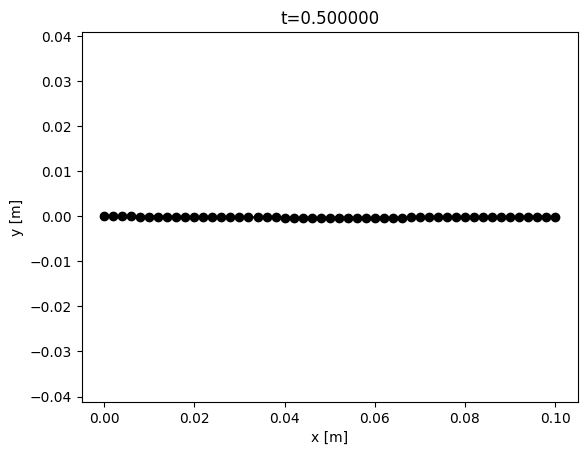

t=0.500000
Iter=0, error=3.687002e-01
Iter=1, error=3.923144e-04
t=0.510000
Iter=0, error=3.673712e-01
Iter=1, error=3.802442e-04
t=0.520000
Iter=0, error=3.660854e-01
Iter=1, error=3.689736e-04
t=0.530000
Iter=0, error=3.648413e-01
Iter=1, error=3.584030e-04
t=0.540000
Iter=0, error=3.636377e-01
Iter=1, error=3.484434e-04
t=0.550000
Iter=0, error=3.624730e-01
Iter=1, error=3.390162e-04
t=0.560000
Iter=0, error=3.613460e-01
Iter=1, error=3.300534e-04
t=0.570000
Iter=0, error=3.602555e-01
Iter=1, error=3.214959e-04
t=0.580000
Iter=0, error=3.592001e-01
Iter=1, error=3.132940e-04
t=0.590000
Iter=0, error=3.581787e-01
Iter=1, error=3.054060e-04
t=0.600000
Iter=0, error=3.571901e-01
Iter=1, error=2.977976e-04
t=0.610000
Iter=0, error=3.562333e-01
Iter=1, error=2.904419e-04
t=0.620000
Iter=0, error=3.553072e-01
Iter=1, error=2.833178e-04
t=0.630000
Iter=0, error=3.544106e-01
Iter=1, error=2.764103e-04
t=0.640000
Iter=0, error=3.535427e-01
Iter=1, error=2.697091e-04
t=0.650000
Iter=0, error=

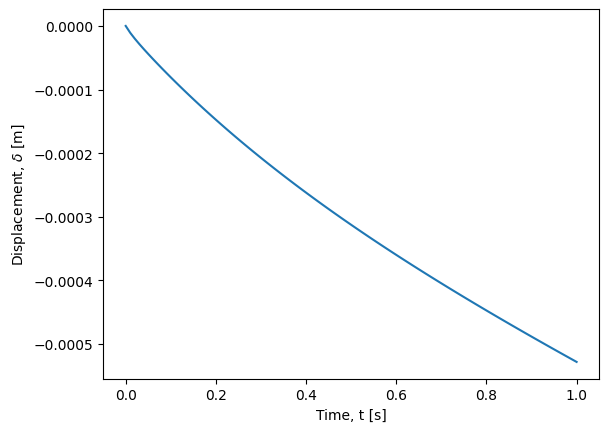

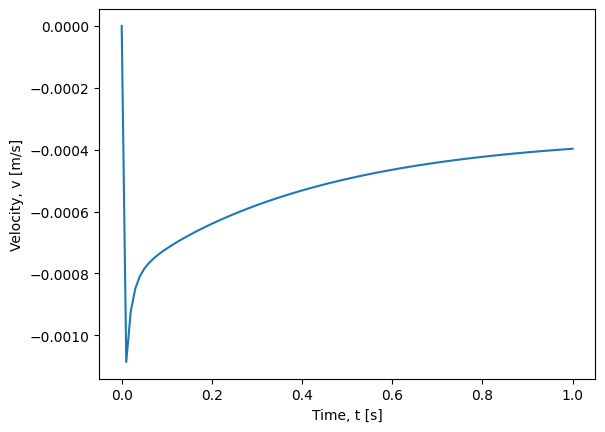

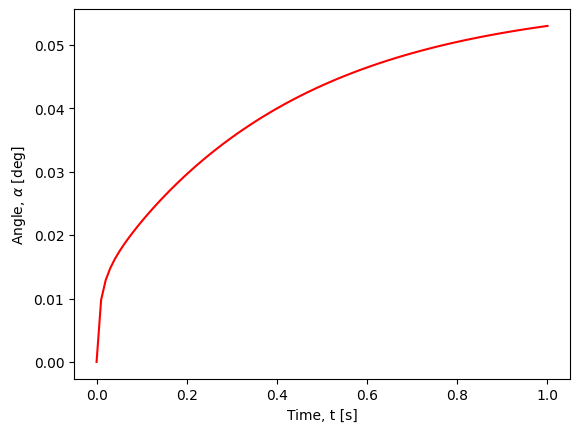

In [371]:
# Number of time steps
Nsteps = round(totalTime / dt)

ctime = 0

all_pos = np.zeros(Nsteps)
all_v = np.zeros(Nsteps)
midAngle = np.zeros(Nsteps)

for timeStep in range(1, Nsteps):  # Python uses 0-based indexing, hence range starts at 1
    print(f't={ctime:.6f}')

    q, error = objfun(q0, q0, u, dt, tol, maximum_iter, m, mMat, EI, EA, W, C, deltaL,
                      free_index) # This line is different from our previous exercise

    if error < 0:
        print('Could not converge. Sorry')
        break  # Exit the loop if convergence fails

    u = (q - q0) / dt  # velocity
    ctime += dt  # current time

    # Update q0
    q0 = q


    if timeStep % plotStep == 0:
      x1 = q[::2]  # Selects every second element starting from index 0
      x2 = q[1::2]  # Selects every second element starting from index 1
      h1 = plt.figure(1)
      plt.clf()  # Clear the current figure
      clear_output(wait=True)  # Clear the previous plot/output: Only for iPython
      plt.plot(x1, x2, 'ko-')  # 'ko-' indicates black color with circle markers and solid lines
      plt.title(f't={ctime:.6f}')  # Format the title with the current time
      plt.axis('equal')  # Set equal scaling
      plt.xlabel('x [m]')
      plt.ylabel('y [m]')
      plt.show()  # Display the figure


    all_pos[timeStep] = q[2*midNode-1]  # Python uses 0-based indexing
    all_v[timeStep] = u[2*midNode-1]

    # Angle at the center
    vec1 = np.array([q[2*midNode-2], q[2*midNode-1], 0]) - np.array([q[2*midNode-4], q[2*midNode-3], 0])
    vec2 = np.array([q[2*midNode], q[2*midNode+1], 0]) - np.array([q[2*midNode-2], q[2*midNode-1], 0])
    midAngle[timeStep] = np.degrees(np.arctan2(np.linalg.norm(np.cross(vec1, vec2)), np.dot(vec1, vec2)))

# Plot
plt.figure(2)
t = np.linspace(0, totalTime, Nsteps)
plt.plot(t, all_pos)
plt.xlabel('Time, t [s]')
plt.ylabel('Displacement, $\\delta$ [m]')
plt.savefig('fallingBeam.png')

plt.figure(3)
plt.plot(t, all_v)
plt.xlabel('Time, t [s]')
plt.ylabel('Velocity, v [m/s]')
plt.savefig('fallingBeam_velocity.png')

plt.figure(4)
plt.plot(t, midAngle, 'r')
plt.xlabel('Time, t [s]')
plt.ylabel('Angle, $\\alpha$ [deg]')
plt.savefig('fallingBeam_angle.png')

plt.show()